__autor__ = Melany Calderón-Osorno

__versión__ = 0.2

__fecha__ = 2025-07-10

#**Abricate Postprocessing Plots**

This tutorial uses the tables generated during the Abricate and pysam post-processing steps to guide you in creating publication-quality figures.

#**Setup notebook environment**

The following code installs the required libraries.

In [27]:
install.packages('patchwork')
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DESeq2")
install.packages('pheatmap')
install.packages('reshape2')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2'”
Old packages: 'data.table', 'purrr', 'waldo'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The following code imports the required libraries.

In [28]:
library(readxl)
library(dplyr)
library(ggplot2)
library(patchwork)
library(DESeq2)
library(tidyr)
library(pheatmap)
library(reshape2)

**Input/Output paths**


**Inputs**

We import the study metadata.

In [29]:
metadata <- read.csv("https://raw.githubusercontent.com/mecalderon/Tutorial_Summer_Retreat/master/results/Abricate_processing/data-deepsea.csv", row.names=1)
metadata

,Sample2,Ocean,Depth,depth.group,Longitude,Latitude,ENA_Run_Accession_ID
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
ERR598947,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR599072,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949
ERR599112,A.270-1000.ERR599112,Indian,-1000,270_1000,43.2948,-15.3379,TARA_B100000378
ERR599115,A.270-1000.ERR599115,Pacific,-650,270_1000,-127.7268,35.2698,TARA_B100001105
SRR3967319,B.2400-4005.SRR3967319,Atlantic,-4003,2400_4005,-33.4100,-15.8300,MP0372


The code reads a tab-separated file from a URL into R, loads it as a matrix using the GENE column as row names, and stores it in the variable **ARG_gene_count**.

In [30]:
ARG_gene_count <- as.matrix(read.csv("https://raw.githubusercontent.com/mecalderon/Tutorial_Summer_Retreat/master/results/Abricate_processing/final_results.tsv", sep="\t", row.names="GENE"))
ARG_gene_count

,ERR598947,ERR599072,ERR599112,ERR599115,SRR3967319
(AGly)aadC,0,0,74,0,0
ANT3-DPRIME,547,0,0,0,0
QACC,0,0,63,0,0
TEM-116,0,696,0,1828,131
aadA27,547,0,0,0,0
-,55463,1379769,4271828,380571,9698


This code reads a tab-separated file from a URL into R, loads it as a matrix using the GENE column as row names, and stores it in the variable **ARG_class_count**.

In [31]:
ARG_class_count <- as.matrix(read.csv("https://raw.githubusercontent.com/mecalderon/Tutorial_Summer_Retreat/master/results/Abricate_processing/final_class.tsv", sep="\t", row.names="GENE"))
ARG_class_count

,ERR598947,ERR599072,ERR599112,ERR599115,SRR3967319
Drug and biocide resistance,0,0,63,0,0
Beta-lactamase,0,696,0,1828,131
-,55463,1379769,4271828,380571,9698
Aminoglycoside,1094,0,74,0,0


This code sorts the columns of both ARG_gene_count and ARG_class_count matrices alphabetically by their column names, then displays the sorted ARG_gene_count matrix.

In [53]:
ARG_gene_count <- ARG_gene_count[, order(colnames(ARG_gene_count))]
ARG_class_count <- ARG_class_count[, order(colnames(ARG_class_count))]
ARG_gene_count

,ERR598947,ERR599072,ERR599112,ERR599115,SRR3967319
(AGly)aadC,0,0,74,0,0
ANT3-DPRIME,547,0,0,0,0
QACC,0,0,63,0,0
TEM-116,0,696,0,1828,131
aadA27,547,0,0,0,0
-,55463,1379769,4271828,380571,9698


The code creates two DESeq2 datasets for differential expression analysis using ARG_gene_count and ARG_class_count matrices, with sample metadata and a design formula based on depth.group.

In [33]:
dds_gene <- DESeqDataSetFromMatrix(countData = ARG_gene_count,
                              colData = metadata,
                              design = ~ depth.group)

dds_class <- DESeqDataSetFromMatrix(countData = ARG_class_count,
                                   colData = metadata,
                                   design = ~ depth.group)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


The code runs the differential expression analysis on the dds_gene and dds_class DESeq2 datasets using the mean fit type for dispersion estimation.

In [34]:
dds_gene <- DESeq(dds_gene, fitType='mean')
dds_class <- DESeq(dds_class, fitType='mean')

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



The code extracts the normalized counts from the DESeq2 objects dds_gene and dds_class, transposes them so samples become rows, converts them into data frames, and stores the results in df_t_gene and df_t_class.

In [35]:
normalized_gene <- counts(dds_gene, normalized = TRUE)
t_gene <- t(normalized_gene)
df_t_gene <- as.data.frame(t_gene)
df_metadata <- as.data.frame(metadata)
df_t_gene

normalized_class <- counts(dds_class, normalized = TRUE)
t_class <- t(normalized_class)
df_t_class <- as.data.frame(t_class)
df_t_class

,(AGly)aadC,ANT3-DPRIME,QACC,TEM-116,aadA27,-
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERR598947,0.000000,2572.126,0.000000,0.0000,2572.126,260800.4
ERR599072,0.000000,0.000,0.000000,131.5561,0.000,260800.4
ERR599112,4.517792,0.000,3.846228,0.0000,0.000,260800.4
ERR599115,0.000000,0.000,0.000000,1252.7049,0.000,260800.4
SRR3967319,0.000000,0.000,0.000000,3522.8763,0.000,260800.4


,Drug and biocide resistance,Beta-lactamase,-,Aminoglycoside
,<dbl>,<dbl>,<dbl>,<dbl>
ERR598947,0.000000,0.0000,260800.4,5144.252046
ERR599072,0.000000,131.5561,260800.4,0.000000
ERR599112,3.846228,0.0000,260800.4,4.517792
ERR599115,0.000000,1252.7049,260800.4,0.000000
SRR3967319,0.000000,3522.8763,260800.4,0.000000


The code adds a new column Sample to the df_t_gene, df_t_class, and df_metadata data frames, assigning row names as sample identifiers to facilitate merging.

In [36]:
df_t_gene$Sample <- rownames(df_t_gene)
df_t_class$Sample <- rownames(df_t_class)
df_metadata$Sample <- rownames(df_metadata)

df_t_gene
df_t_class

,(AGly)aadC,ANT3-DPRIME,QACC,TEM-116,aadA27,-,Sample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ERR598947,0.000000,2572.126,0.000000,0.0000,2572.126,260800.4,ERR598947
ERR599072,0.000000,0.000,0.000000,131.5561,0.000,260800.4,ERR599072
ERR599112,4.517792,0.000,3.846228,0.0000,0.000,260800.4,ERR599112
ERR599115,0.000000,0.000,0.000000,1252.7049,0.000,260800.4,ERR599115
SRR3967319,0.000000,0.000,0.000000,3522.8763,0.000,260800.4,SRR3967319


,Drug and biocide resistance,Beta-lactamase,-,Aminoglycoside,Sample
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ERR598947,0.000000,0.0000,260800.4,5144.252046,ERR598947
ERR599072,0.000000,131.5561,260800.4,0.000000,ERR599072
ERR599112,3.846228,0.0000,260800.4,4.517792,ERR599112
ERR599115,0.000000,1252.7049,260800.4,0.000000,ERR599115
SRR3967319,0.000000,3522.8763,260800.4,0.000000,SRR3967319


The code merges the df_t_gene data frame with the df_metadata data frame by the Sample column, adding metadata information to the gene count data.

In [37]:
df_t_gene <- df_t_gene %>% left_join(df_metadata, by = 'Sample')
df_t_gene
colnames(df_t_gene)

(AGly)aadC,ANT3-DPRIME,QACC,TEM-116,aadA27,-,Sample,Sample2,Ocean,Depth,depth.group,Longitude,Latitude,ENA_Run_Accession_ID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
0.000000,2572.126,0.000000,0.0000,2572.126,260800.4,ERR598947,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
0.000000,0.000,0.000000,131.5561,0.000,260800.4,ERR599072,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949
4.517792,0.000,3.846228,0.0000,0.000,260800.4,ERR599112,A.270-1000.ERR599112,Indian,-1000,270_1000,43.2948,-15.3379,TARA_B100000378
0.000000,0.000,0.000000,1252.7049,0.000,260800.4,ERR599115,A.270-1000.ERR599115,Pacific,-650,270_1000,-127.7268,35.2698,TARA_B100001105
0.000000,0.000,0.000000,3522.8763,0.000,260800.4,SRR3967319,B.2400-4005.SRR3967319,Atlantic,-4003,2400_4005,-33.4100,-15.8300,MP0372


[1] "(AGly)aadC"           "ANT3-DPRIME"          "QACC"                
 [4] "TEM-116"              "aadA27"               "-"                   
 [7] "Sample"               "Sample2"              "Ocean"               
[10] "Depth"                "depth.group"          "Longitude"           
[13] "Latitude"             "ENA_Run_Accession_ID"

This code merges the df_t_class data frame with the df_metadata data frame by the Sample column, adding metadata information to the class count data.

In [38]:
df_t_class <- df_t_class %>% left_join(df_metadata, by = 'Sample')
df_t_class
colnames(df_t_class)

Drug and biocide resistance,Beta-lactamase,-,Aminoglycoside,Sample,Sample2,Ocean,Depth,depth.group,Longitude,Latitude,ENA_Run_Accession_ID
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
0.000000,0.0000,260800.4,5144.252046,ERR598947,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
0.000000,131.5561,260800.4,0.000000,ERR599072,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949
3.846228,0.0000,260800.4,4.517792,ERR599112,A.270-1000.ERR599112,Indian,-1000,270_1000,43.2948,-15.3379,TARA_B100000378
0.000000,1252.7049,260800.4,0.000000,ERR599115,A.270-1000.ERR599115,Pacific,-650,270_1000,-127.7268,35.2698,TARA_B100001105
0.000000,3522.8763,260800.4,0.000000,SRR3967319,B.2400-4005.SRR3967319,Atlantic,-4003,2400_4005,-33.4100,-15.8300,MP0372


[1] "Drug and biocide resistance" "Beta-lactamase"             
 [3] "-"                           "Aminoglycoside"             
 [5] "Sample"                      "Sample2"                    
 [7] "Ocean"                       "Depth"                      
 [9] "depth.group"                 "Longitude"                  
[11] "Latitude"                    "ENA_Run_Accession_ID"

The code groups the gene count data by depth.group, sums the counts of selected genes for each group, reshapes the data from wide to long format with gene names and their corresponding values, and stores the result in df_summarized.

In [39]:
df_summarized <- df_t_gene %>%
  group_by(`depth.group`) %>%
  summarise(`(AGly)aadC` = sum(`(AGly)aadC`),
            `ANT3-DPRIME` = sum(`ANT3-DPRIME`),
            `QACC` = sum(`QACC`),
            `TEM-116` = sum(`TEM-116`),
            `aadA27` = sum(`aadA27`)) %>% pivot_longer(cols = `(AGly)aadC`: `aadA27`, names_to = "gene", values_to = "valor")
df_summarized

depth.group,gene,valor
<chr>,<chr>,<dbl>
2400_4005,(AGly)aadC,0.000000
2400_4005,ANT3-DPRIME,0.000000
2400_4005,QACC,0.000000
2400_4005,TEM-116,3522.876266
2400_4005,aadA27,0.000000
270_1000,(AGly)aadC,4.517792
270_1000,ANT3-DPRIME,2572.126023
270_1000,QACC,3.846228
270_1000,TEM-116,1384.261036


The code creates a boxplot showing the total abundance of selected ARGs (antibiotic resistance genes) across depth groups.

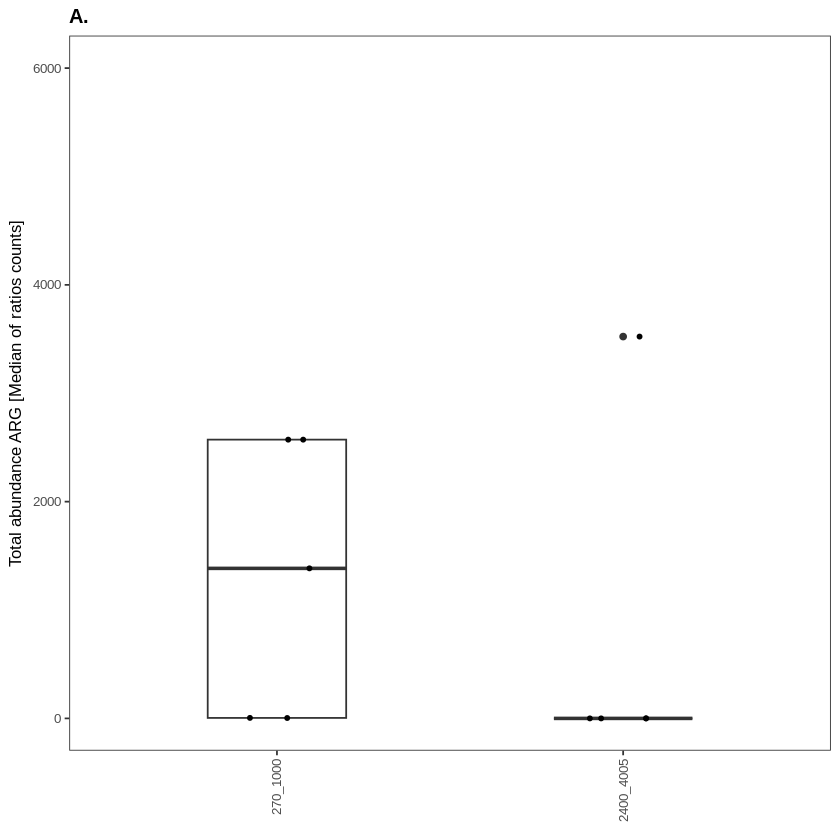

In [40]:
total_ARG <-  df_summarized %>% group_by(depth.group) %>%
  ggplot(aes(x=factor(`depth.group`, levels=c("270_1000", "2400_4005")), y=valor)) +
  geom_boxplot(width=0.4) + geom_jitter(width = 0.1, size=1)+
  coord_cartesian(ylim=c(2,6000)) + # adjust y-axis
  #scale_fill_manual(values=c("#c2d2e9","#1F78B4")) + #specify custom colors
  theme_bw()+ ggtitle("A.") + ylab("Total abundance ARG [Median of ratios counts]") + xlab("")+
  theme(axis.text.x = element_text(size=8,angle = 90,vjust = 0.5, hjust=1),
        axis.text.y = element_text(size = 8),
        axis.title.y = element_text(size = 10),
        axis.title.x = element_blank(),
        legend.text = element_text(size = 10),
        legend.position="none",
        panel.grid = element_blank(),
        plot.title = element_text(size = 12, face = "bold"))
total_ARG

This code prepares gene abundance data by converting counts to relative abundances (%), reshaping the data to long format, grouping and summarizing gene percentages per sample, then merging with metadata to create data1 for further visualization.

In [41]:
sample_name <- df_t_gene$Sample
df_t_gene <- subset(df_t_gene, select = -6)
df_t_gene = t(df_t_gene[1:5])
colnames(df_t_gene) <- sample_name
gene_name <- c("(AGly)aadC", "ANT3-DPRIME", "QACC", "TEM-116", "aadA27")
df_t_gene <- as.data.frame(df_t_gene)
df_t_gene <- sapply(df_t_gene[1:5], prop.table) * 100
df_t_gene <- as.data.frame(df_t_gene)
df_t_gene$gene <- gene_name

data1 <- df_t_gene %>%
  pivot_longer(cols =   ERR598947:SRR3967319,
               names_to = "Sample",
               values_to = "valor")%>%
  group_by(Sample, gene)%>%
  summarise(sum_gene = sum(valor))%>%
  pivot_wider(names_from = "gene",
              values_from = "sum_gene")
data1 <- data1 %>%
  pivot_longer(cols = `(AGly)aadC`:`aadA27`,
               names_to = "gene",
               values_to = "valor")

data1<-
  data1 %>%
  left_join(df_metadata)
head(data1)

`summarise()` has grouped output by 'Sample'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample)`


Sample,gene,valor,Sample2,Ocean,Depth,depth.group,Longitude,Latitude,ENA_Run_Accession_ID
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
ERR598947,(AGly)aadC,0,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR598947,ANT3-DPRIME,50,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR598947,QACC,0,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR598947,TEM-116,0,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR598947,aadA27,50,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR599072,(AGly)aadC,0,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949


The code creates a stacked bar plot showing the relative abundance of selected ARGs per sample, faceted by ocean.

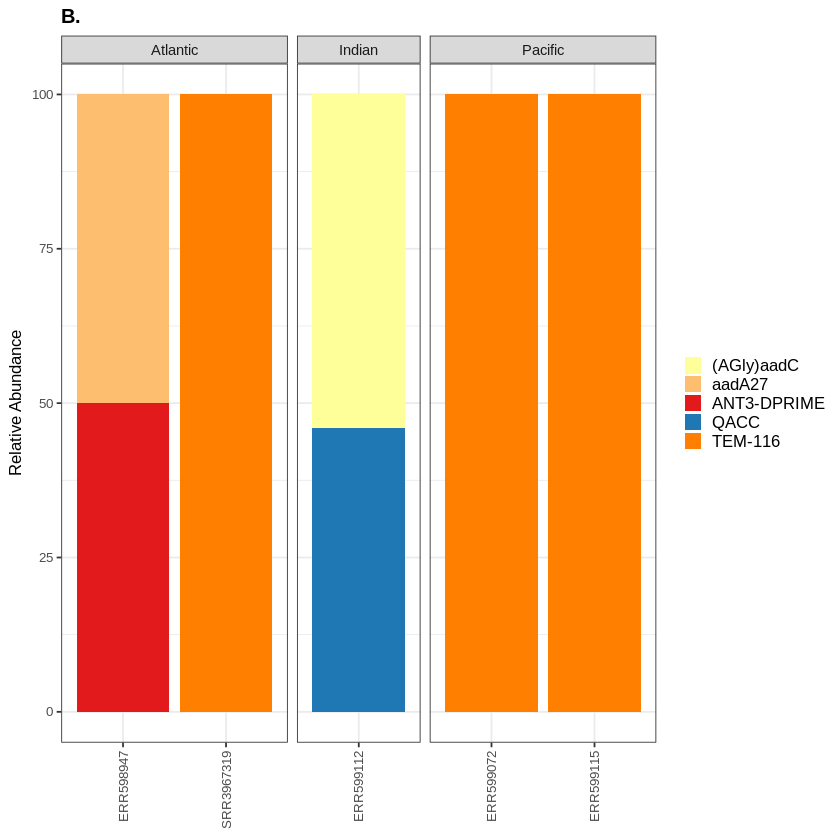

In [42]:
abundance_ARG <- ggplot(data=data1, aes(x=Sample, y=valor,fill=gene))+
  geom_bar(stat = "identity") +
  facet_grid(~ Ocean, scales = "free_x",  space = "free_x") +
  scale_fill_manual(values =  c("#FFFF99", "#FDBF6F", "#E31A1C", "#1F78B4","#FF7F00", "#6A3D9A"))+
  theme_bw()+ggtitle("B.")+ylab("Relative Abundance") + xlab("")+
  theme(plot.title = element_text(hjust = 0,size = 12, face="bold"),
        axis.text.x = element_text(size=8,angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_text(size = 8),
        axis.title.y = element_text(size = 10),
        axis.title.x = element_blank(),
        legend.text = element_text(size = 10),
        legend.position = "right",
        legend.key.size = unit(0.4, "cm"),
        legend.title = element_blank())
abundance_ARG

The code combines the total_ARG and abundance_ARG plots and saves the resulting figure.


Saving 6.67 x 6.67 in image


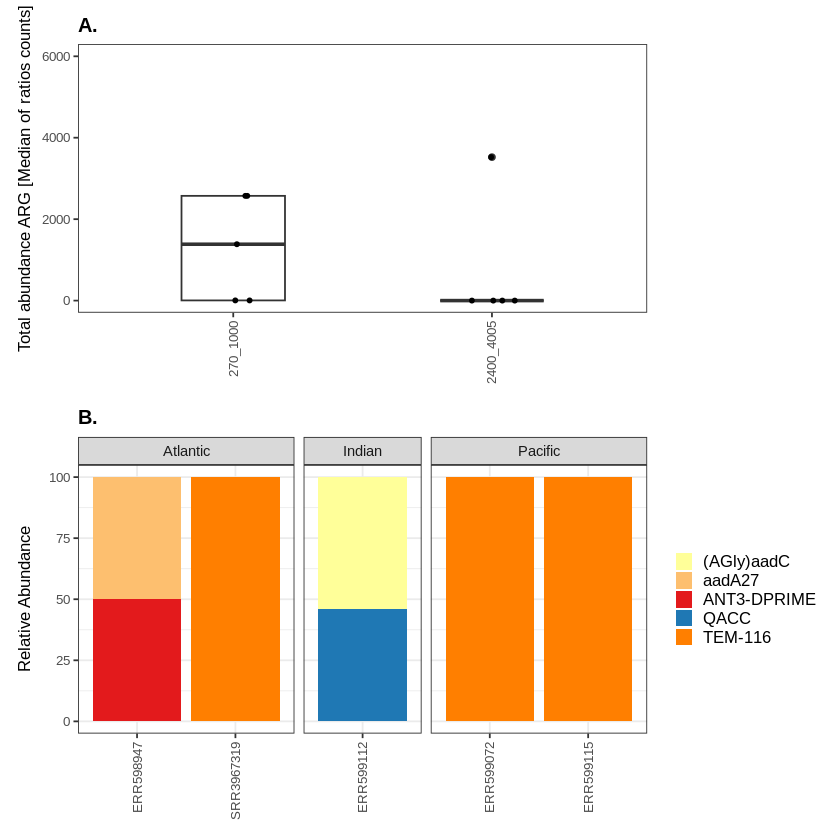

In [43]:
total_ARG/abundance_ARG
ggsave("ARG.png")

The code processes class-level ARG abundance data by computing relative abundances, reshaping and summarizing the data per sample, then merging it with metadata to generate data2 for downstream visualization.

In [44]:
sample_name <- df_t_class$Sample
df_t_class <- subset(df_t_class, select = -3)
df_t_class = t(df_t_gene[1:3])
colnames(df_t_class) <- sample_name
class_name <- c("Drug and biocide resistance",
                "Beta-lactamase", "Aminoglycoside")
df_t_class <- as.data.frame(df_t_class)
df_t_class <- sapply(df_t_class[1:5], prop.table) * 100
df_t_class <- as.data.frame(df_t_class)
df_t_class$class <- class_name

data2 <- df_t_class %>%
  pivot_longer(cols =   ERR598947:SRR3967319,
               names_to = "Sample",
               values_to = "valor")%>%
  group_by(Sample, class)%>%
  summarise(sum_class = sum(valor))%>%
  pivot_wider(names_from = 'class',
              values_from = "sum_class")


data2 <- data2 %>%
  pivot_longer(cols = `Aminoglycoside`:`Drug and biocide resistance`,
               names_to = "class",
               values_to = "valor")

data2<-
  data2 %>%
  left_join(df_metadata)
head(data2)

`summarise()` has grouped output by 'Sample'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample)`


Sample,class,valor,Sample2,Ocean,Depth,depth.group,Longitude,Latitude,ENA_Run_Accession_ID
<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
ERR598947,Aminoglycoside,100,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR598947,Beta-lactamase,0,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR598947,Drug and biocide resistance,0,A.270-1000.ERR598947,Atlantic,-700,270_1000,4.6685,-31.0198,TRAA_B100000470
ERR599072,Aminoglycoside,0,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949
ERR599072,Beta-lactamase,0,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949
ERR599072,Drug and biocide resistance,100,A.270-1000.ERR599072,Pacific,-696,270_1000,-129.5986,-23.2232,TARA_B100000949


The code groups the data2 data frame by ARG class and depth group, then calculates summary statistics including mean, sum, count, minimum, and maximum of the relative abundance (valor) for each group.

In [45]:
data2 %>%  group_by(class, `depth.group`) %>% summarise(mean = mean(valor), sum = sum(valor), n = n(), min = min(valor), max = max(valor))

`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.


class,depth.group,mean,sum,n,min,max
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
Aminoglycoside,2400_4005,0,0,1,0,0
Aminoglycoside,270_1000,50,200,4,0,100
Beta-lactamase,2400_4005,0,0,1,0,0
Beta-lactamase,270_1000,25,100,4,0,100
Drug and biocide resistance,2400_4005,100,100,1,100,100
Drug and biocide resistance,270_1000,25,100,4,0,100


This code creates a stacked bar plot (abundance_class) showing the relative abundance of ARG classes per sample, faceted by ocean.

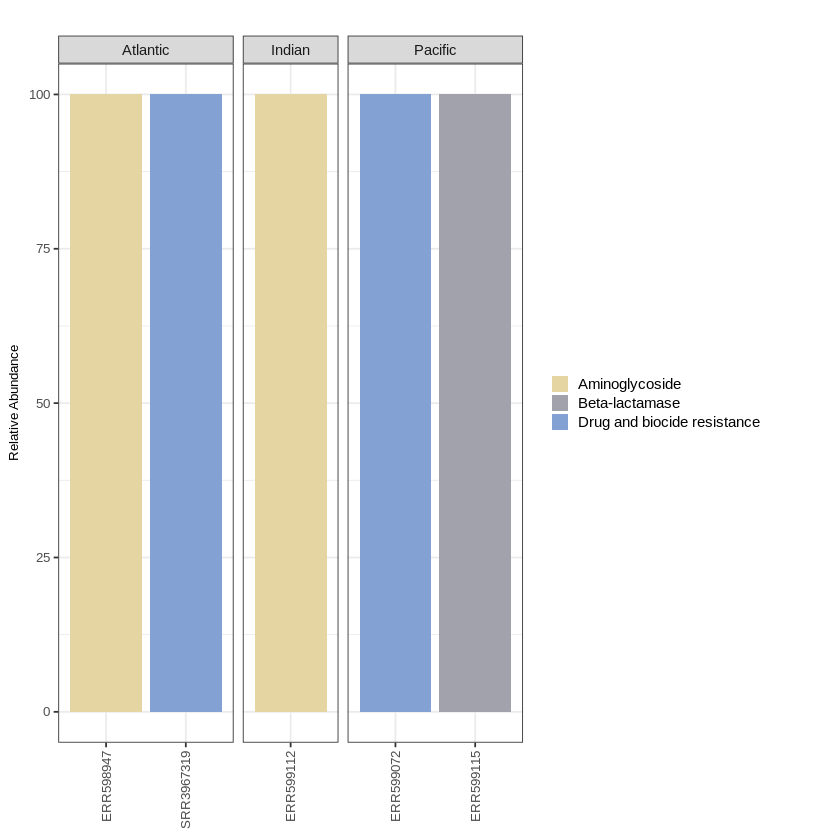

In [46]:
abundance_class <- ggplot(data=data2, aes(x=Sample, y=valor,fill=class))+
  geom_bar(stat = "identity") +
  facet_grid(~ Ocean, scales = "free_x",  space = "free_x") +
  scale_fill_manual(values = c("#e5d5a3", "#a2a2ac", "#83a2d3",  "#3a4e7a", "#6da3c7", "#b9b8ae", "#c2d2e9"))+
  theme_bw()+ggtitle("")+ylab("Relative Abundance") + xlab("")+
  theme(plot.title = element_text(hjust = 0,size = 12, face="bold"),
        axis.text.x = element_text(size=8,angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_text(size = 8),
        axis.title.y = element_text(size = 8),
        axis.title.x = element_blank(),
        legend.text = element_text(size = 9),
        legend.position = "right",
        legend.key.size = unit(0.4, "cm"),
        legend.title = element_blank())
abundance_class

**Heatmap ARG class**

 Get differential expression results

The code retrieves the differential abundance results for ARG classes and genes from the DESeq2 analysis using the results() function and stores them in res_class and res_gene, respectively.


In [47]:
res_class <- results(dds_class)  # Get DESeq2 results
res_gene <- results(dds_gene)  # Get DESeq2 results

This code applies a variance-stabilizing transformation (vsd_class, vsd_gene) and a log-like normalization (ntd) to the DESeq2 datasets for ARG classes and genes, preparing them for downstream visualization.

In [48]:
vsd_class <- varianceStabilizingTransformation(dds_class, fitType='mean')
vsd_gene <- varianceStabilizingTransformation(dds_gene, fitType='mean')

ntd <- normTransform(dds_class)

This code selects the ARG classes based on normalized counts, prepares sample annotations with ocean and depth group colors, and generates a heatmap of the variance-stabilized counts using pheatmap, including the annotated metadata.

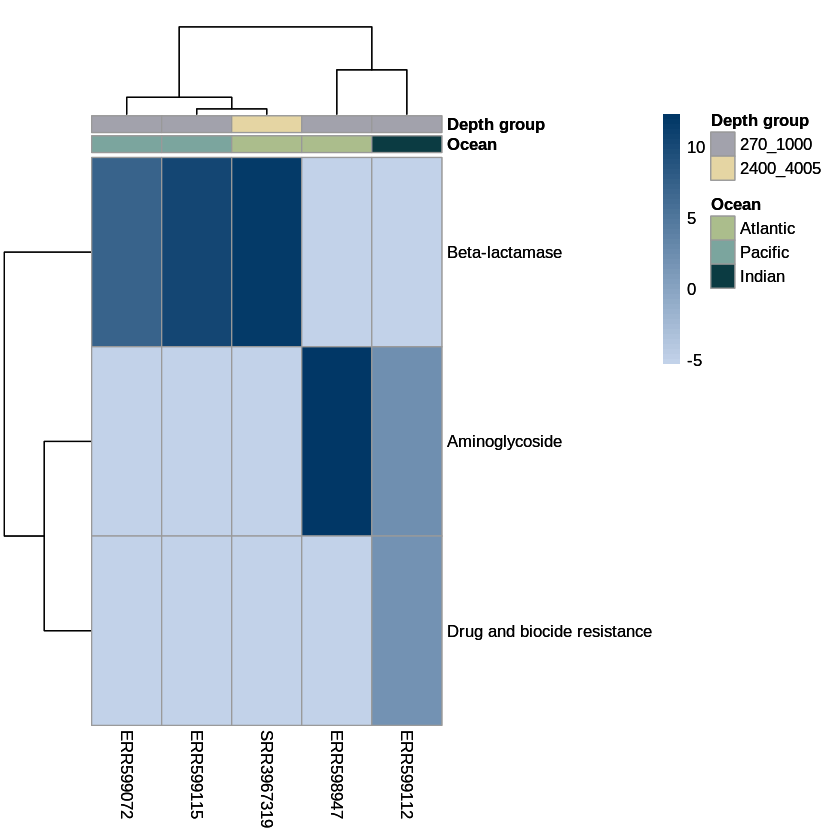

In [49]:
annotations <- c("Ocean", "depth.group")

# Crea una copia de df_class para modificar los nombres de las columnas
select <- order(rowMeans(counts(dds_class, normalized=TRUE)), decreasing=TRUE)[2:4]
df_class <- as.data.frame(colData(dds_class)[,c("Ocean","depth.group")])
colnames(df_class) <- c("Ocean", "Depth group")

annot_colors=list(Ocean=c(`Atlantic`="#abbd8c", `Pacific`="#7ba59e", `Indian`="#0b3b42"),
                  `Depth group`=c(`270_1000`="#a2a2ac",`2400_4005`="#e5d5a3"))
heatmap <- pheatmap(assay(vsd_class)[select, ], annotation_col=df_class,
                    color=colorRampPalette(c("#c2d2e9","#013766"))(50),
                    main = "", annotation_colors = annot_colors)
heatmap

The code extracts the selected variance-stabilized counts, transposes them to have samples as rows, converts to a data frame, adds sample names to both the data and annotation frames, then merges them into a single data frame called data.

In [50]:
heatmap_data <- as.data.frame(assay(vsd_class)[select, ])
heatmap_data <- t(heatmap_data)
heatmap_data <- as.data.frame(heatmap_data)
samples <- rownames(df_class)
df_class$sample_name <- samples
heatmap_data$sample_name <- samples

data <- merge(heatmap_data, df_class)
data

sample_name,Aminoglycoside,Beta-lactamase,Drug and biocide resistance,Ocean,Depth group
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
ERR598947,12.328760,-5.321928,-5.321928,Atlantic,270_1000
ERR599072,-5.321928,7.040083,-5.321928,Pacific,270_1000
ERR599112,2.191454,-5.321928,1.962019,Indian,270_1000
ERR599115,-5.321928,10.290888,-5.321928,Pacific,270_1000
SRR3967319,-5.321928,11.782559,-5.321928,Atlantic,2400_4005


The code reshapes the merged data from wide to long format using melt, then groups it by variable and ocean to calculate summary statistics like mean, sum, count, minimum, and maximum for each group.

In [51]:
melted_data <- reshape2::melt(data, id.vars = c("sample_name", "Ocean", "Depth group"))
melted_data %>%  group_by(variable, `Ocean`) %>% summarise(mean = mean(value), sum = sum(value),
                                                           n = n(), min = min(value), max = max(value))

`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.


variable,Ocean,mean,sum,n,min,max
<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
Aminoglycoside,Atlantic,3.503416,7.006832,2,-5.321928,12.328760
Aminoglycoside,Indian,2.191454,2.191454,1,2.191454,2.191454
Aminoglycoside,Pacific,-5.321928,-10.643856,2,-5.321928,-5.321928
Beta-lactamase,Atlantic,3.230315,6.460630,2,-5.321928,11.782559
Beta-lactamase,Indian,-5.321928,-5.321928,1,-5.321928,-5.321928
Beta-lactamase,Pacific,8.665486,17.330971,2,7.040083,10.290888
Drug and biocide resistance,Atlantic,-5.321928,-10.643856,2,-5.321928,-5.321928
Drug and biocide resistance,Indian,1.962019,1.962019,1,1.962019,1.962019
Drug and biocide resistance,Pacific,-5.321928,-10.643856,2,-5.321928,-5.321928


The code creates a heatmap using ggplot2 that visualizes normalized counts of ARG classes across depth groups and oceans, faceting by ocean, then saves the plot as "classARG.png".

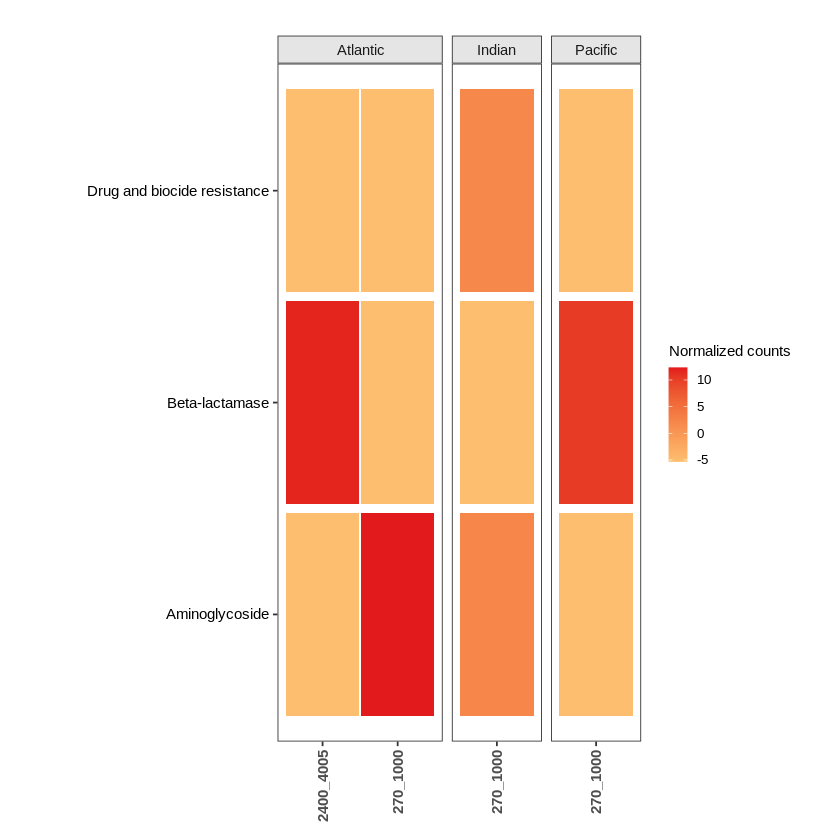

In [52]:
heatmap <- ggplot(melted_data, aes(x = `Depth group`, y = variable, fill = value)) +
  geom_tile(color = "transparent",  width = 0.98, height = 0.96) +
  scale_fill_gradient(low = "#FDBF6F", high = "#E31A1C") +  # Define la escala de colores
  facet_grid(~ Ocean , scales = "free_x", space = "free_x") +
  labs(title = "") +
  theme_bw()+ggtitle("")+ylab("") + xlab("")+
  theme(plot.title = element_text(hjust = 0,size = 12, face="bold"),
        axis.text.x = element_text(size=9,angle = 90, vjust = 0.5, hjust=1, face="bold"),
        axis.text.y = element_text(size = 9, color = "black"),
        axis.title.y = element_text(size = 8),
        axis.title.x = element_blank(),
        legend.text = element_text(size = 8),
        legend.position = "right",
        legend.key.size = unit(0.4, "cm"),
        legend.title =  element_text(size = 9),
        panel.grid.major = element_blank(),  # Elimina las líneas de la cuadrícula
        panel.grid.minor = element_blank(),
        strip.background = element_rect(fill = "gray90"))+
  labs(fill = "Normalized counts")
print(heatmap)
ggsave("classARG.png", width = 6, height = 4)